# BCH

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns 
import time
from scipy.stats import norm
sns.set()

In [2]:
# Standard plotly imports
import plotly
# Authenticate with your account
plotly.tools.set_credentials_file(username='Abcde54321',                                              
                                  api_key='hcooLngkiMrN7qXHBs5s')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
BCH = pd.read_csv('BCH_merged.txt', sep = ',')
List_BCH = []
for i in range(len(BCH)):
    List_BCH.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(BCH['time'][i])))
BCH['datetime'] = pd.DataFrame(List_BCH)
BCH['datetime'] = pd.to_datetime(BCH['datetime'])
BCH = BCH.set_index('datetime')

In [8]:
BCH.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3920 entries, 2018-01-02 11:00:00 to 2018-06-14 19:00:00
Data columns (total 22 columns):
Unnamed: 0             3920 non-null int64
time                   3920 non-null int64
positive_score_en      3920 non-null float64
negative_score_en      3920 non-null float64
score_en               3920 non-null float64
positive_volume_en     3920 non-null int64
negative_volume_en     3920 non-null int64
volume_ratio_en        3920 non-null float64
total_volume_en        3920 non-null int64
total_volume_non_en    3920 non-null int64
total_volume_global    3920 non-null int64
close                  3920 non-null float64
high                   3920 non-null float64
low                    3920 non-null float64
open                   3920 non-null float64
volumefrom             3920 non-null float64
volumeto               3920 non-null float64
logclose               3920 non-null float64
loghigh                3920 non-null float64
loglow          

In [9]:
BCH_sent = BCH[['positive_score_en', 'negative_score_en', 'score_en', 'positive_volume_en', 'negative_volume_en', 
                'volume_ratio_en', 'total_volume_en', 'total_volume_non_en', 'total_volume_global']]

In [10]:
BCH_sent.head()

,positive_score_en,negative_score_en,score_en,positive_volume_en,negative_volume_en,volume_ratio_en,total_volume_en,total_volume_non_en,total_volume_global
datetime,,,,,,,,,
2018-01-02 11:00:00,2.047340,1.339500,0.707840,5,1,5.0000,49,3,52
2018-01-02 12:00:00,1.674538,2.082700,-0.408162,24,3,8.0000,187,42,229
2018-01-02 13:00:00,1.749251,1.791425,-0.042174,39,8,4.8750,190,31,221
2018-01-02 14:00:00,1.617091,1.742150,-0.125059,45,4,11.2500,240,13,253
2018-01-02 15:00:00,1.765536,1.599843,0.165693,36,7,5.1429,266,24,290


## A - Log-Return 1h

In [4]:
from sklearn.model_selection import TimeSeriesSplit
r = BCH['logclose'].diff(1)
tscv = TimeSeriesSplit(n_splits=5)

In [5]:
r = pd.Series(r)
r.describe()

count    3919.000000
mean       -0.000253
std         0.016505
min        -0.109988
25%        -0.007647
50%        -0.000114
75%         0.006954
max         0.140533
Name: logclose, dtype: float64

In [6]:
skew_return = r.skew()
kurtosis_return = r.kurtosis()
skew_return, kurtosis_return

(0.23114368858774717, 6.74031190114885)

### 1 - Fitting Normal Distribution

In [7]:
from scipy.stats import t, norm, ks_2samp
from numpy import linspace
from pylab import plot,show,hist,figure,title

In [8]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = norm.fit(r_v[train])
    test_fit = stats.norm.rvs(size=len(test), loc=param[0], scale=param[1])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

In [9]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(-0.00045443219465433193, 0.018953083618627912)

In [10]:
KS_statistic

[[0.09188361408882084, 0.007468375052415055],
 [0.1699846860643186, 9.814570682251508e-09],
 [0.19754977029096477, 1.198137559787472e-11],
 [0.08422664624808576, 0.01823895867720212],
 [0.16539050535987754, 2.722359719984312e-08]]

#### a - PDF

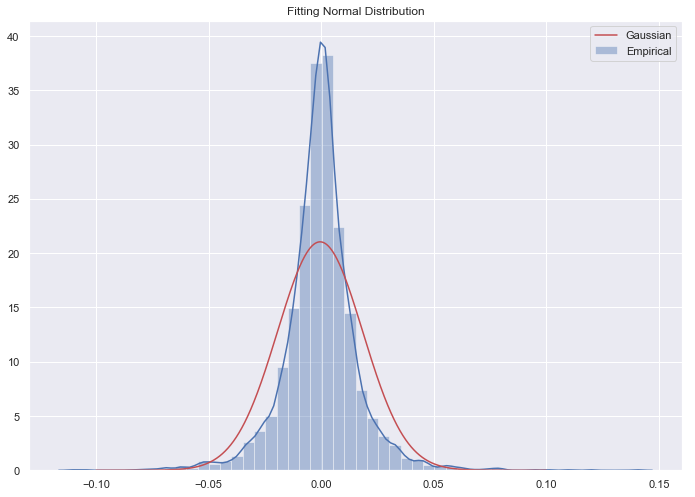

In [11]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r_v))
pdf_fitted = norm.pdf(x, loc=param_optim[0], scale=param_optim[1])

plt.title('Fitting Normal Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'Gaussian')
plt.legend()
plt.show()

#### b - CCDF

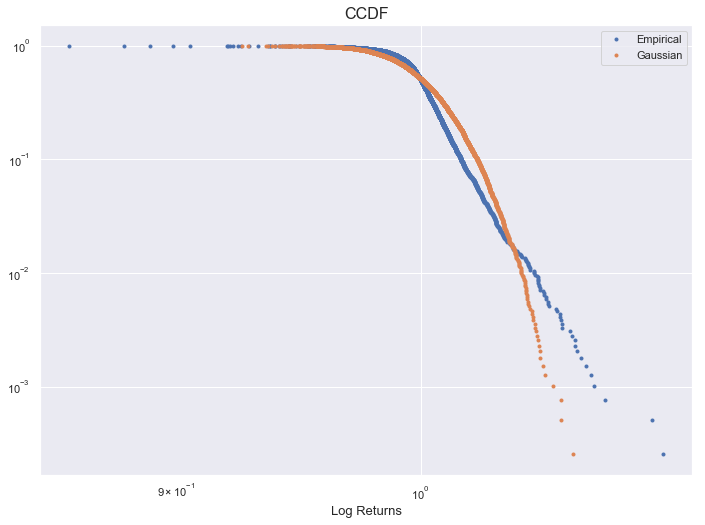

In [12]:
x1 = np.sort(r_v)
x2 = norm.rvs(loc=param_optim[0], scale=param_optim[1], size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)
c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'Gaussian')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plots

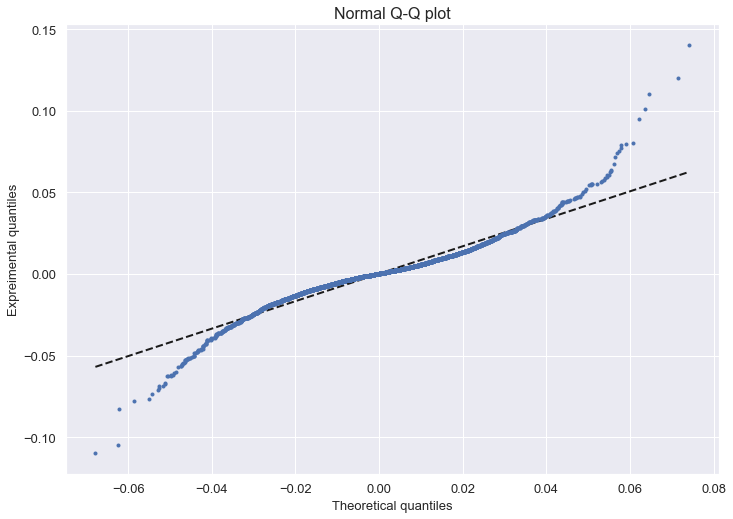

In [13]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Normal Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Expreimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

In [14]:
param_optim

(-0.00045443219465433193, 0.018953083618627912)

#### d - Tests and Scores

##### Information Criteria

In [15]:
nloglval = np.sum(np.log(param_optim[1]*np.sqrt(2*np.pi)) + (r_v - param_optim[0])**2 / (2 * param_optim[1]**2))
kvals = len(param_optim)
AIC = 2 * nloglval + 2 * kvals
BIC = 2 * nloglval + kvals*np.log(len(r_v))
CAIC = 2 * nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = 2 * nloglval + 2*kvals*np.log(np.log(len(r_v)))

##### Tests

##### Kolmogorov Smirnov 

In [16]:
r_fit = stats.norm.rvs(size=len(r_v), loc=param[0], scale=param[1])
KS_stat = stats.ks_2samp(r_v, r_fit)

In [17]:
KS_stat[0]

0.09441183975503953

##### Anderson Darling

In [18]:
AD_stat = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [19]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS_stat[0], AD_stat[0]], columns = ['Normal'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,Normal
AIC,-20905.467866
BIC,-20892.920683
CAIC,-20890.920683
AICc,-20905.464802
HQC,-20901.015592
KS,0.094412
AD,59.956963


### 2 - Fitting Student-t Distribution

In [33]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = t.fit(r_v[train])
    test_fit = stats.t.rvs(size=len(test), loc=param[1], scale=param[2], df = param[0])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

In [34]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(2.6062486545583505, -0.0002516573724563527, 0.01108359755596051)

#### a - PDF

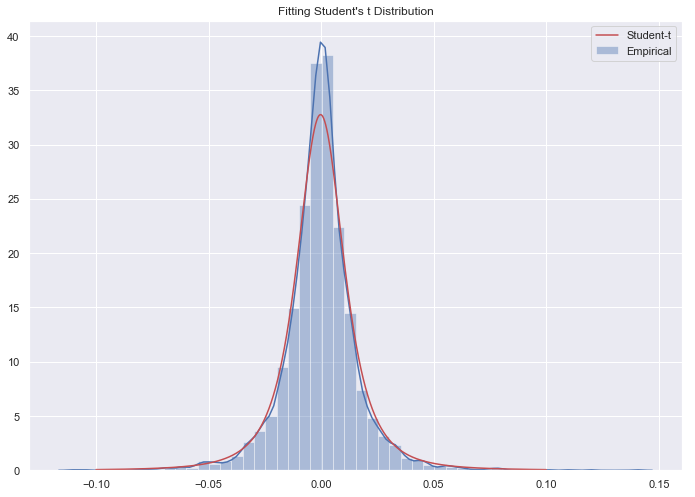

In [35]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r)-1)
pdf_fitted = t.pdf(x, loc=param_optim[1], scale=param_optim[2], df=param_optim[0])

plt.title('Fitting Student\'s t Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'Student-t')
plt.legend()
plt.show()

#### b - CCDF

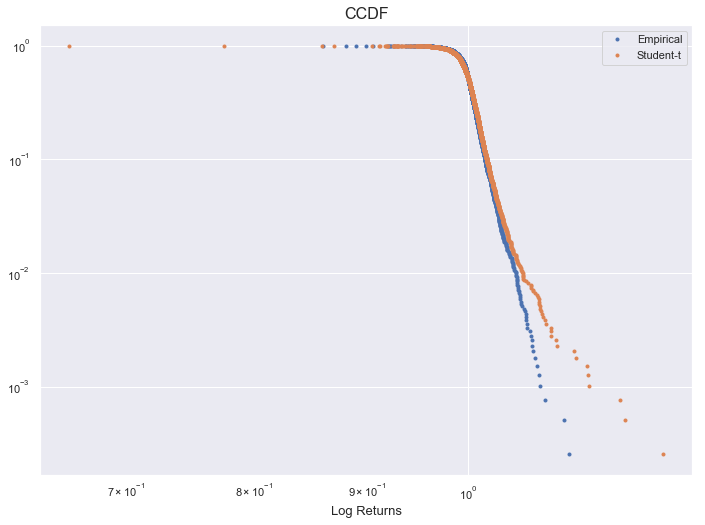

In [36]:
x1 = np.sort(r_v)
x2 = t.rvs(loc=param_optim[1], scale=param_optim[2], df=param_optim[0],size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)

c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'Student-t')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plots

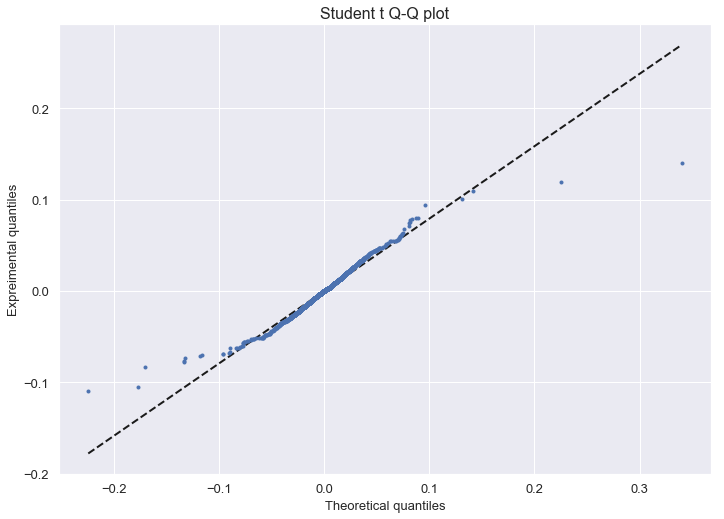

In [37]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Student t Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Expreimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

#### d - Tests and Scores

##### Information Criteria

In [38]:
from scipy.special import gamma

In [39]:
nu = param_optim[0]
mu = param_optim[1]
std = param_optim[2]
nloglval = np.sum(np.log(gamma(0.5*(nu + 1))*(1 + ((r_v - mu)**2)/(nu*std**2))**(-0.5*(nu+1))/(gamma(nu*0.5)*np.sqrt(np.pi*nu*std**2))))
kvals = len(param_optim)
AIC = -2*nloglval + 2 * kvals
BIC = -2*nloglval + kvals*np.log(len(r_v))
CAIC = -2*nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = -2*nloglval + 2*kvals*np.log(np.log(len(r_v)))

##### Tests

##### Kolmogorov Smirnov

In [40]:
#Kolmogorov-Smirnov
r_fit = stats.t.rvs(size=len(r_v), loc=param_optim[1], scale=param_optim[2], df = param_optim[0])
KS = stats.ks_2samp(r_v, r_fit)

##### Anderson Darling

In [41]:
AD = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [32]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS[0], AD[0]], columns = ['Student-t'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,Student-t
AIC,-21809.616919
BIC,-21790.796144
CAIC,-21787.796144
AICc,-21809.610789
HQC,-21802.938507
KS,0.057157
AD,24.865874


### 3 - Fittting the Skew-t Distribution

In [52]:
from scipy.stats import nct

In [57]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = nct.fit(r_v[train])
    test_fit = stats.nct.rvs(size=len(test), loc=param[2], scale=param[3], df = param[0], nc = param[1])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning:

invalid value encountered in double_scalars



In [58]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(2.610879243167025,
 -0.06981924335559765,
 0.0005302706954852811,
 0.011082266562635468)

#### a - PDF

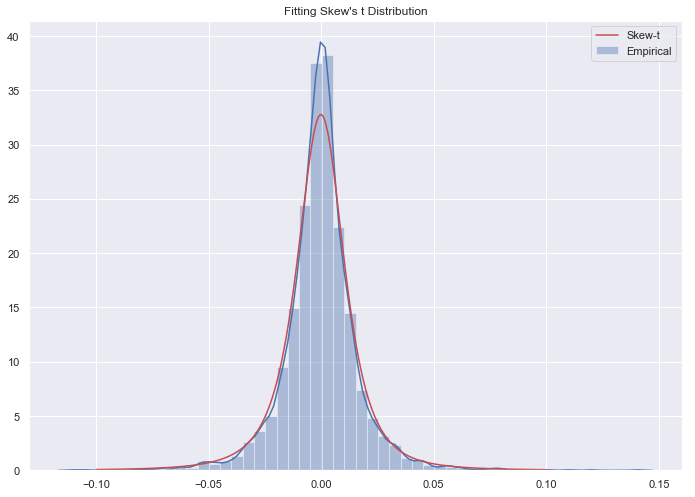

In [59]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r)-1)
pdf_fitted = nct.pdf(x, loc=param_optim[2], scale=param_optim[3], df=param_optim[0], nc = param_optim[1])

plt.title('Fitting Skew\'s t Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'Skew-t')
plt.legend()
plt.show()

#### b - CCDF

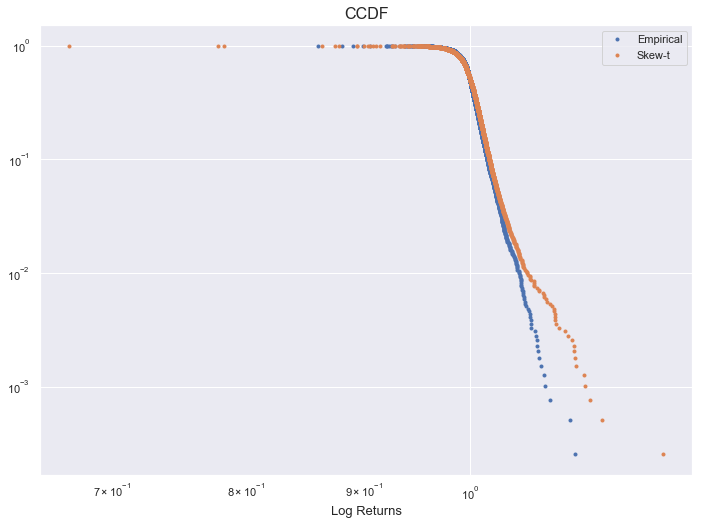

In [60]:
x1 = np.sort(r_v)
x2 = nct.rvs(loc=param_optim[2], scale=param_optim[3], df=param_optim[0], nc = param_optim[1],size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)

c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'Skew-t')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plot

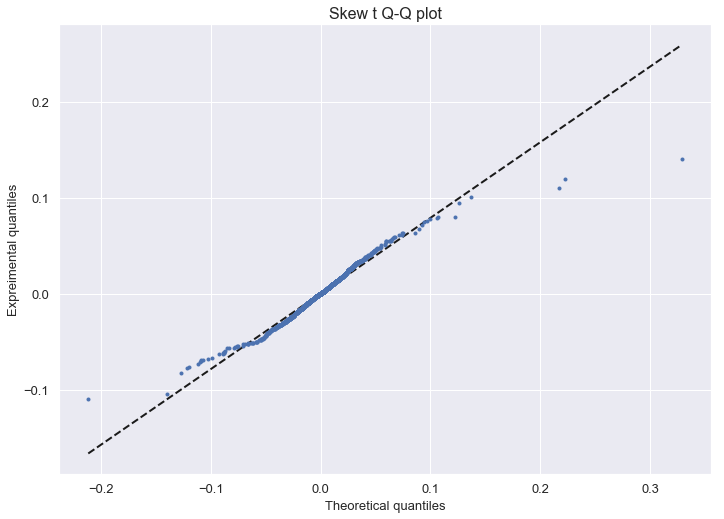

In [61]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Skew t Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Expreimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

#### d - Tests and Scores

##### Information Criteria

In [62]:
df = param_optim[0]
nc = param_optim[1]
mu = param_optim[3]
std = param_optim[3]
nloglval = np.sum(np.log(nct.pdf(r_v, df = df, nc = nc, loc=mu, scale=std)))
kvals = len(param_optim)
AIC = -2*nloglval + 2 * kvals
BIC = -2*nloglval + kvals*np.log(len(r_v))
CAIC = -2*nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = -2*nloglval + 2*kvals*np.log(np.log(len(r_v)))

##### Tests

###### Kolmogorov-Smirnov

In [63]:
#Kolmogorov-Smirnov
r_fit = stats.nct.rvs(size=len(r_v), loc=param_optim[2], scale=param_optim[3], df=param_optim[0], nc = param_optim[1])
KS = stats.ks_2samp(r_v, r_fit)

###### Anderson Darling

In [64]:
AD = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [65]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS[0], AD[0]], columns = ['Skew-t'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,Skew-t
AIC,-19639.794129
BIC,-19614.699761
CAIC,-19610.699761
AICc,-19639.783909
HQC,-19630.889579
KS,0.041592
AD,6.749044


### 4 - Fitting the Laplace distribution

In [21]:
from scipy.stats import laplace, lognorm, norminvgauss

In [67]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = laplace.fit(r_v[train])
    test_fit = stats.laplace.rvs(size=len(test), loc=param[0], scale=param[1])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

In [68]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(-0.0003157114687283944, 0.012703542075048313)

#### a - PDF

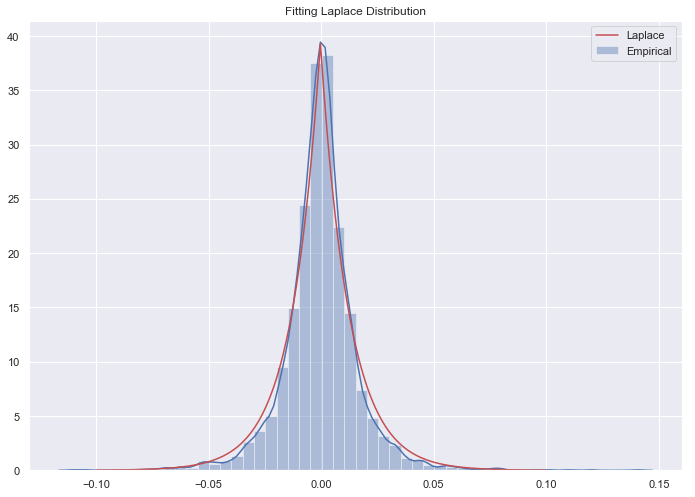

In [69]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r)-1)
pdf_fitted = laplace.pdf(x, loc=param_optim[0], scale=param_optim[1])

plt.title('Fitting Laplace Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'Laplace')
plt.legend()
plt.show()

#### b - CCDF

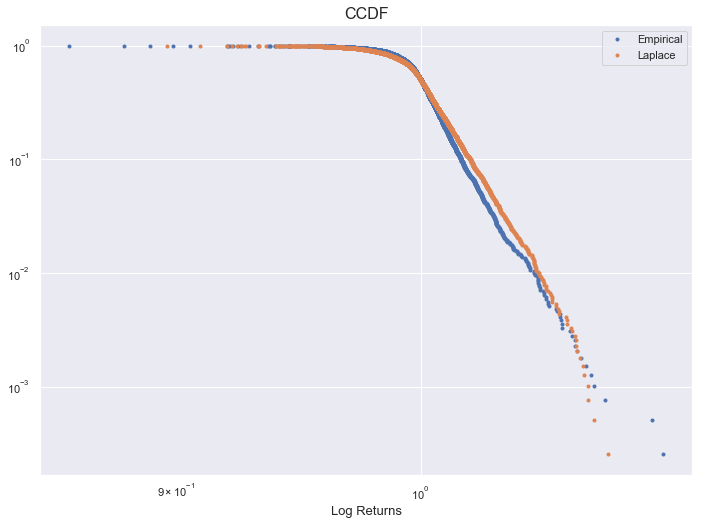

In [70]:
x1 = np.sort(r_v)
x2 = laplace.rvs(loc=param_optim[0], scale=param_optim[1],size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)

c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'Laplace')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plots

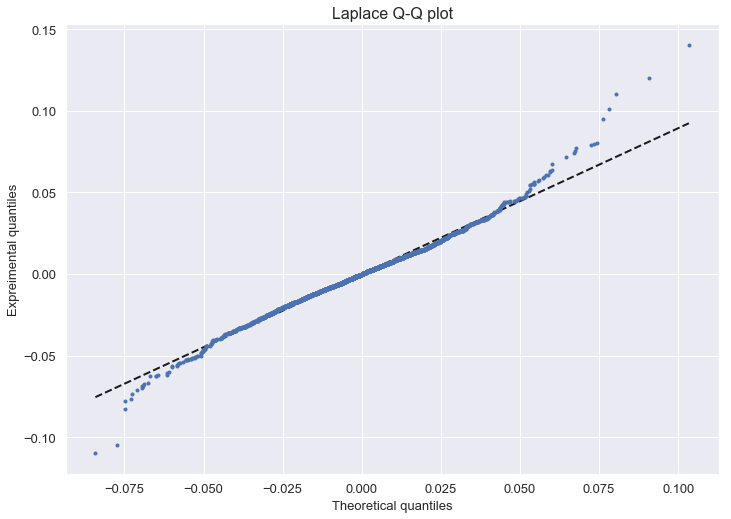

In [71]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Laplace Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Expreimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

#### d - Tests & Scores

##### Information Criteria

In [72]:
mu = param_optim[0]
std = param_optim[1]
nloglval = np.sum(-np.log(2*std) - abs(r_v - mu)/std)
kvals = len(param_optim)
AIC = -2*nloglval + 2 * kvals
BIC = -2*nloglval + kvals*np.log(len(r_v))
CAIC = -2*nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = -2*nloglval + 2*kvals*np.log(np.log(len(r_v)))

##### Tests

##### Kolmogorov Smirnov

In [73]:
#Kolmogorov-Smirnov
r_fit = laplace.rvs(size=len(r_v), loc=param_optim[0], scale=param_optim[1])
KS = stats.ks_2samp(r_v, r_fit)

##### Anderson Darling

In [74]:
AD = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [75]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS[0], AD[0]], columns = ['Skew-t'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,Skew-t
AIC,-21950.325491
BIC,-21937.778307
CAIC,-21935.778307
AICc,-21950.322426
HQC,-21945.873216
KS,0.041847
AD,11.565551


### 5 - Fitting the Normal Inverse Gaussian Distribution

In [22]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = norminvgauss.fit(r_v[train])
    test_fit = stats.norminvgauss.rvs(size=len(test), a=param[0], b=param[1], loc=param[2], scale=param[3])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

In [23]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(0.7110982154715912,
 -0.16615726527238106,
 0.003464499152775754,
 0.01657299463897227)

#### a - PDF

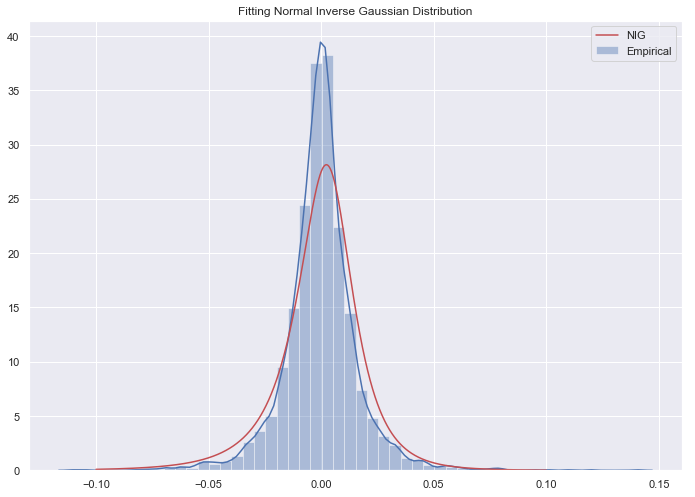

In [24]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r)-1)
pdf_fitted = norminvgauss.pdf(x, a=param_optim[0], b=param_optim[1], loc=param_optim[2], scale=param_optim[3])

plt.title('Fitting Normal Inverse Gaussian Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'NIG')
plt.legend()
plt.show()

#### b - CCDF

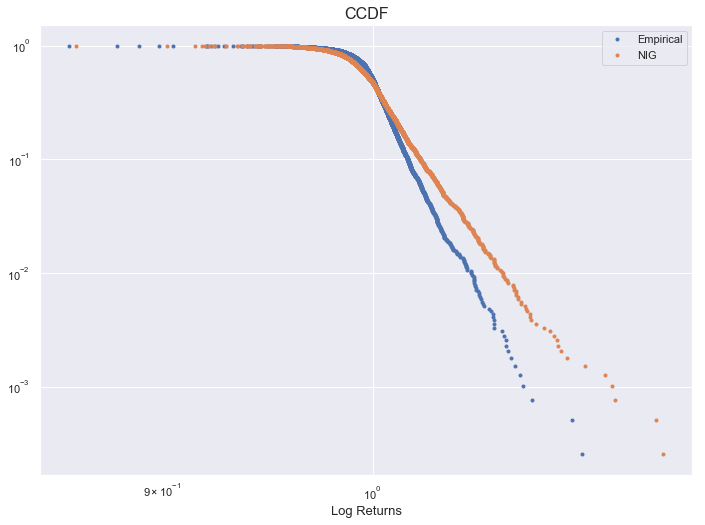

In [25]:
x1 = np.sort(r_v)
x2 = norminvgauss.rvs(a = param_optim[0], b = param_optim[1], loc=param_optim[2], scale=param_optim[3],size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)

c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'NIG')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plot

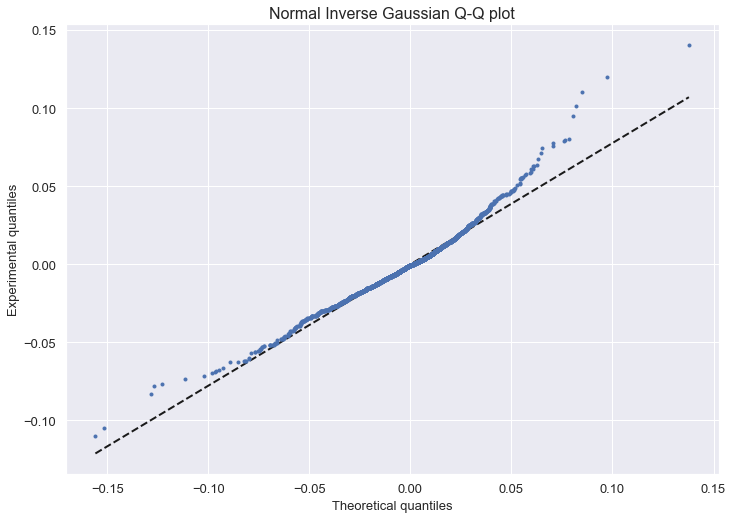

In [26]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Normal Inverse Gaussian Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Experimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

#### d - Test and Scores

##### Information Criteria

In [27]:
alpha = param_optim[0]
beta = param_optim[1]
mu = param_optim[2]
std = param_optim[3]
nloglval = np.sum(np.log(norminvgauss.pdf(r_v, alpha, beta, loc=mu, scale=std)))
kvals = len(param_optim)
AIC = -2*nloglval + 2 * kvals
BIC = -2*nloglval + kvals*np.log(len(r_v))
CAIC = -2*nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = -2*nloglval + 2*kvals*np.log(np.log(len(r_v)))

In [28]:
alpha, beta, mu, std

(0.7110982154715912,
 -0.16615726527238106,
 0.003464499152775754,
 0.01657299463897227)

In [29]:
AIC

-21676.37053179829

##### Tests

##### Kolmogorov Smirnov

In [30]:
stats.kstest(r_v, 'norminvgauss', args = [alpha, beta])

KstestResult(statistic=0.5386116158652215, pvalue=0.0)

In [31]:
stats.anderson(r_v, 'norminvgauss')

ValueError: Invalid distribution; dist must be 'norm', 'expon', 'gumbel', 'extreme1' or 'logistic'.

In [32]:
r_fit = norminvgauss.rvs(size=len(r_v), a = param_optim[0], b = param_optim[1], loc=param_optim[2], scale=param_optim[3])
KS = stats.ks_2samp(r_v, r_fit)

##### Anderson Darling

In [33]:
AD = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [34]:
KS, AD

(Ks_2sampResult(statistic=0.07501913753508549, pvalue=4.669942209193093e-10),
 Anderson_ksampResult(statistic=34.63522887098259, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=0.0011828081422949957))

In [115]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS[0], AD[0]], columns = ['Skew-t'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,Skew-t
AIC,-21990.033400
BIC,-21964.939033
CAIC,-21960.939033
AICc,-21990.023181
HQC,-21981.128850
KS,0.032406
AD,6.432521


### 6 - Fitting Lognormal Distribution

In [76]:
r_v = r.values[1:]
from scipy import stats
parameters = []
KS_statistic = []
for train,test in tscv.split(r_v):
    param = lognorm.fit(r_v[train])
    test_fit = stats.lognorm.rvs(size=len(test), s=param[0], loc=param[1], scale=param[2])
    KS_statistic.append(list(stats.ks_2samp(r_v[test], test_fit)))
    parameters.append(param)

In [77]:
param_optim = parameters[np.argmax(np.array(KS_statistic)[:,0])]
param_optim

(0.02099369011893985, -0.9020623205242766, 0.9014091469572891)

#### a - PDF

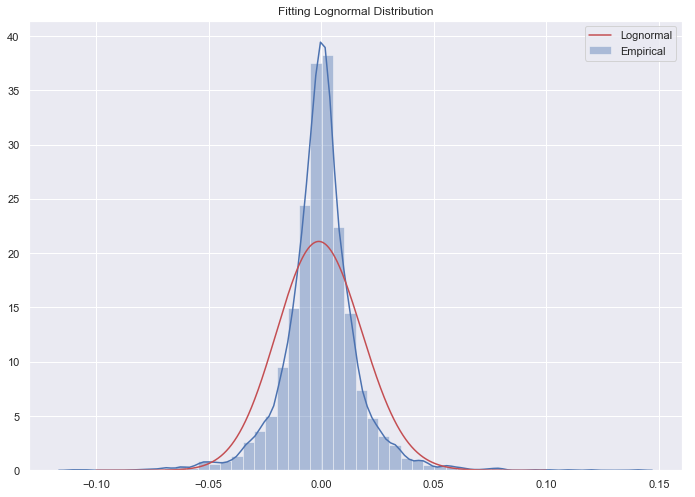

In [78]:
#Distribution of the returns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(r_v, label = 'Empirical')

#Distribution of fitted Student-t distribution
x = linspace(-0.1,0.1,len(r)-1)
pdf_fitted = lognorm.pdf(x, s=param_optim[0], loc=param_optim[1], scale=param_optim[2])

plt.title('Fitting Lognormal Distribution')
plt.plot(x,pdf_fitted,'r-',label = 'Lognormal')
plt.legend()
plt.show()

#### b - CCDF

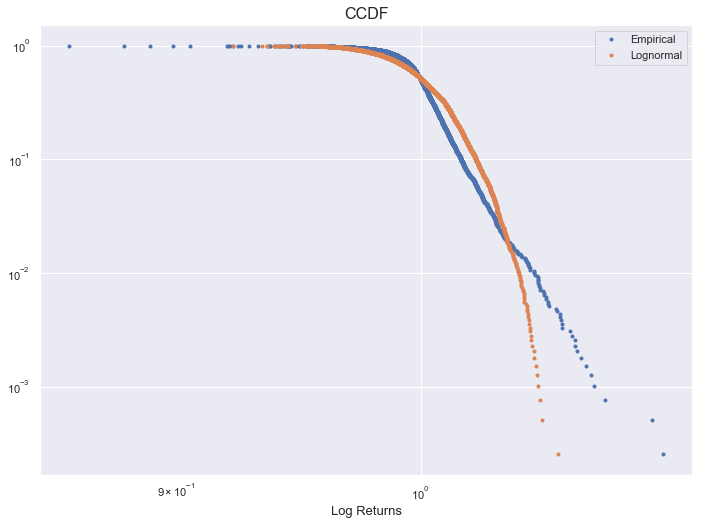

In [79]:
x1 = np.sort(r_v)
x2 = lognorm.rvs(s = param_optim[0], loc=param_optim[1], scale=param_optim[2],size = len(x1))
x2.sort()
y = np.arange(1, len(x1)+1)/len(x1)

c1 = 1 - x1
c2 = 1 - x2
plt.loglog(c1,y,marker = '.', linestyle = 'none', label = 'Empirical')
plt.loglog(c2,y,marker = '.', linestyle = 'none', label = 'Lognormal')
plt.xlabel('Log Returns', size = 13)
plt.title('CCDF', size = 16)
plt.legend()

#### c - Q-Q Plot

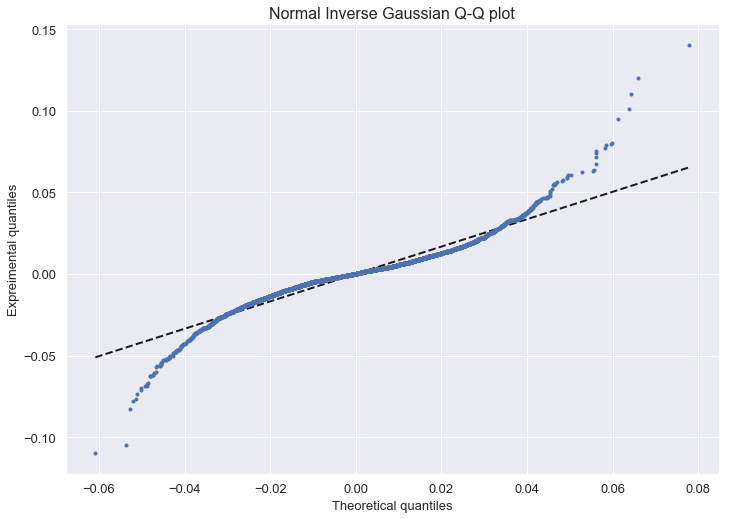

In [80]:
z = np.polyfit(x2,x1, 1)
p = np.poly1d(z)
plt.plot(x2,p(x2),"k--", linewidth=2)
plt.plot(x2,x1,'.', linewidth=2)
plt.title("Normal Inverse Gaussian Q-Q plot", size=16)
plt.xlabel("Theoretical quantiles", size=13)
plt.ylabel("Expreimental quantiles", size=13)
plt.tick_params(labelsize=13)
plt.show()

#### d - Tests and Scores

##### Information Criteria

In [81]:
s = param_optim[0]
mu = param_optim[1]
std = param_optim[2]
nloglval = np.sum(np.log(lognorm.pdf(r_v, s, loc=mu, scale=std)))
kvals = len(param_optim)
AIC = -2*nloglval + 2 * kvals
BIC = -2*nloglval + kvals*np.log(len(r_v))
CAIC = -2*nloglval + kvals*(1+ np.log(len(r_v)))
AICc = AIC + 2*kvals*(kvals + 1)/(len(r_v)-kvals-1)
HQC = -2*nloglval + 2*kvals*np.log(np.log(len(r_v)))

In [82]:
AIC

-20910.756537834204

##### Tests

##### Kolmogorov Smirnov

In [83]:
r_fit = lognorm.rvs(size=len(r_v), s = param_optim[0], loc=param_optim[1], scale=param_optim[2])
KS = stats.ks_2samp(r_v, r_fit)

In [84]:
KS

Ks_2sampResult(statistic=0.10870119928553204, pvalue=1.1990405393403607e-20)

##### Anderson Darling

In [85]:
AD = stats.anderson_ksamp([r_v, r_fit])

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1680: UserWarning:

approximate p-value will be computed by extrapolation



In [86]:
AD

Anderson_ksampResult(statistic=82.02967036489413, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752]), significance_level=2.5356435004460133e+36)

In [87]:
pd.DataFrame([AIC, BIC, CAIC, AICc, HQC, KS[0], AD[0]], columns = ['LogNormal'], index = ['AIC', 'BIC', 'CAIC', 'AICc', 'HQC', 'KS', 'AD'])

,LogNormal
AIC,-20910.756538
BIC,-20891.935762
CAIC,-20888.935762
AICc,-20910.750408
HQC,-20904.078125
KS,0.108701
AD,82.029670


### 7 - Fitting the tails distributions

In [51]:
from math import *
from scipy.stats import powerlaw, genpareto

#### a - Right-tail

In [52]:
# Parameters
thresholds = np.linspace(0.01, 0.15, 15) # Defining tails as top p% of returns (both positive and negative)
bts = 0.8 # Fraction of data to be retained in each bootstrap sample
Nbts = 500 # Number of bootstrap samples
alpha = 0.9 # Significance level

In [65]:
alpha_min = []
alpha_max = []
MSE = []
alphas = []
T_ = []
for p in thresholds:
    r_v = np.sort(r_v)
    r_right = r_v[floor((1-p)*len(r_v)):] # Selecting top p% of returns
    N = len(r_right) # Number of returns selected as right tail
    alpha_right = N/np.sum(np.log(r_right/min(r_right)))#Maximum-likelihood estimate for right tail exponent
    right_fitted = powerlaw.rvs(size = len(r_right), a = alpha_right)
    ## Kolmogorov-Smirnov Test
    alphas.append(alpha_right)
    KS_Stat = list(stats.ks_2samp(r_right, right_fitted))
    T = KS_Stat[0]*(np.sqrt(len(r_v) + 0.12 + 0.11/np.sqrt(len(r_v))))
    T_.append(T)
    if KS_Stat[1] < 0.01: # Bootstrap happens
        alpha_right_bts = [] #Vector to collect bootstrap estimates for right tail exponent
        for i in range(Nbts):
            r_bts = np.random.permutation(r_v)# Random permutation of returns
            r_bts = r_bts[:floor(0.8*len(r_v))] # Bootstrapping bts% of returns 
            r_bts = np.sort(r_bts) # Sorting bootstrapped returns
            r_right_bts = r_bts[floor((1-p)*len(r_bts)):] # Selecting top p% of returns
            N_bts = len(r_right_bts) #  Number of bootstrapped returns
            alpha_right_bts.append(N_bts/np.sum(np.log(r_right_bts/min(r_right_bts))))
        alpha_right_bts = np.sort(alpha_right_bts) #Sorting bootstrap estimates for right tail exponent
        alpha_min.append(alpha_right_bts[floor(0.5*(1-alpha)*Nbts)])
        alpha_max.append(alpha_right_bts[floor(0.5*(1+alpha)*Nbts)])
        B = alpha_right_bts.mean() - alpha_right
        S = alpha_right_bts.std()
        MSE.append(100*(B**2 + S**2)/N_bts)
    
    else: # No bootstrap
        alpha_min.append(None)
        alpha_max.append(None)
        MSE.append(None)

In [66]:
pd.DataFrame([alpha_min, alphas, alpha_max, MSE, list(np.argsort(MSE)+1)], columns = thresholds, 
             index = ['Lower Bound', 'Tail exponent', 'Upper Bound', 'MSE', 'MSE Ranks']).T

,Lower Bound,Tail exponent,Upper Bound,MSE,MSE Ranks
0.01,2.896501,3.276323,3.659372,0.185203,15.0
0.02,2.717751,2.966709,3.198595,0.036108,13.0
0.03,2.793875,3.055108,3.244904,0.022881,14.0
0.04,2.547166,2.692449,2.902175,0.009525,12.0
0.05,2.491283,2.627652,2.765963,0.004584,11.0
0.06,2.274024,2.355182,2.520744,0.003560,10.0
0.07,2.181570,2.267291,2.385634,0.001896,9.0
0.08,2.102379,2.181561,2.274971,0.001144,8.0
0.09,1.973484,2.047786,2.146248,0.000961,7.0
0.10,1.897381,1.991203,2.062018,0.000842,6.0


#### b - Left-tail

In [57]:
from sklearn.metrics import mean_squared_error

In [67]:
alpha_min = []
alpha_max = []
MSE = []
alphas = []
for p in thresholds:
    r_v = np.sort(r_v)
    r_left = r_v[:floor(p*len(r_v))] # Selecting top p% of returns
    N = len(r_left) # Number of returns selected as right tail
    alpha_left = N/np.sum(np.log(r_left/min(r_left)))#Maximum-likelihood estimate for right tail exponent
    x_left = np.linspace(min(r_left),max(r_left),len(r_left));
    left_fitted = alpha_left*(x_left/min(r_left))**(-alpha_left-1)/min(r_left)
    ## Kolmogorov-Smirnov Test

    alphas.append(alpha_left)
    KS_Stat = list(stats.ks_2samp(r_left, left_fitted))
    if KS_Stat[1] < 0.05: # Bootstrap happens
        alpha_left_bts = [] #Vector to collect bootstrap estimates for right tail exponent
        for i in range(Nbts):
            r_bts = np.random.permutation(r_v)# Random permutation of returns
            r_bts = r_bts[:floor(0.8*len(r_v))] # Bootstrapping bts% of returns 
            r_bts = np.sort(r_bts) # Sorting bootstrapped returns
            r_left_bts = r_bts[:floor(p*len(r_bts))] # Selecting top p% of returns
            N_bts = len(r_left_bts) #  Number of bootstrapped returns
            alpha_left_bts.append(N_bts/np.sum(np.log(r_left_bts/min(r_left_bts))))
        alpha_left_bts = np.sort(alpha_left_bts) #Sorting bootstrap estimates for right tail exponent
        alpha_min.append(alpha_left_bts[floor(0.5*(1-alpha)*Nbts)])
        alpha_max.append(alpha_left_bts[floor(0.5*(1+alpha)*Nbts)])
        MSE.append(100*mean_squared_error([alpha_left]*500, alpha_left_bts)/N_bts)
    
    else: # No bootstrap
        alpha_min.append(None)
        alpha_max.append(None)
        MSE.append(None)

In [69]:
pd.DataFrame([alpha_min, alphas, alpha_max, MSE, list(np.argsort(MSE)+1)], columns = thresholds, 
             index = ['Lower Bound', 'Tail exponent', 'Upper Bound', 'MSE', 'MSE Ranks']).T

,Lower Bound,Tail exponent,Upper Bound,MSE,MSE Ranks
0.01,-1.922656,-1.709103,-1.641984,0.303068,15.0
0.02,-1.448583,-1.312808,-1.264731,0.039175,14.0
0.03,-1.210853,-1.116681,-1.081697,0.013131,13.0
0.04,-1.083638,-1.008566,-0.983289,0.006326,10.0
0.05,-0.996159,-0.933150,-0.910378,0.003460,11.0
0.06,-0.930049,-0.875956,-0.858672,0.001910,12.0
0.07,-0.883452,-0.832250,-0.817432,0.001458,9.0
0.08,-0.838323,-0.794092,-0.780670,0.000690,8.0
0.09,-0.806249,-0.761502,-0.749301,0.000684,7.0
0.10,-0.767005,-0.734090,-0.723677,0.000407,6.0


### 7 - VaR and CVaR

#### a - Non-parametric approach - Historical

In [72]:
r = np.sort(r)
r = r[:-1]
CI = [0.1, 0.05, 0.025, 0.01]
VaR = []
CVaR = []
for i in CI:
    var = np.percentile(r, i*100)*(-1)
    cvar = r[r <= var].mean()*(-1)
    VaR.append(var)
    CVaR.append(cvar)

In [73]:
pd.DataFrame([VaR,CVaR], columns = ['10%', '5%', '2.5%', '1%'], index = ['VaR', 'CVaR'])

,10%,5%,2.5%,1%
VaR,0.017586,0.026122,0.034262,0.050256
CVaR,0.003354,0.002194,0.001462,0.000835


#### b - Parametric approach

#####         Normal

In [74]:
h = 24 # horizon of 1 hour
mu_h = r.mean()  # this is the mean of % returns over 10 days - 10%
sig_h = r.std() # this is the vol over the horizon
alpha = 0.01

In [75]:
alphas = [0.1, 0.05, 0.025, 0.01]
CVaR = []
VaR = []
for i in range(len(alphas)):
    CVaR.append(alphas[i]**-1 * norm.pdf(norm.ppf(alphas[i]))*sig_h - mu_h)
    VaR.append((norm.ppf(1-alphas[i])*sig_h - mu_h))

In [76]:
pd.DataFrame([VaR,CVaR], columns = ['10%', '5%', '2.5%', '1%'], index = ['VaR', 'CVaR'])

,10%,5%,2.5%,1%
VaR,0.021244,0.027184,0.032336,0.038327
CVaR,0.028985,0.034016,0.038515,0.043868


##### Student

In [77]:
h = 24 # horizon of 1 hour
mu_h = np.mean(r)  
sig_h = np.std(r) 
alpha = 0.01
# Student t best fit (finding: nu)
parm = t.fit(r)
nu, mu_t, sig_t = parm

In [84]:
alphas = [0.1, 0.05, 0.025, 0.01]
CVaR = []
VaR = []
for i in range(len(alphas)):
    xanu = t.ppf(alphas[i], nu)
    CVaR.append(-1*(alphas[i]**-1*(1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu)*sig_h - mu_h))
    VaR.append((h*(nu-2)/nu)**0.5 * t.ppf(1-alphas[i], nu)*sig_h - h*mu_h)

In [85]:
pd.DataFrame([VaR,CVaR], columns = ['10%', '5%', '2.5%', '1%'], index = ['VaR', 'CVaR'])

,10%,5%,2.5%,1%
VaR,0.073702,0.104795,0.142311,0.206682
CVaR,0.033107,0.054885,0.081747,0.127230
